# Can Fork

- [ ] Does it matter whos turn it is??

In [2]:

from stockfish_explain.utils.concepts import (
    evaluate_concepts_one,
    classification_cost,
    value_counts

)
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.linear_model import RidgeClassifier, Ridge, LogisticRegression
from lightgbm import LGBMClassifier, LGBMRegressor
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import logging
import shelve
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer


regression_models = [
    Ridge(),
    MLPRegressor(solver='adam', alpha=1e-4, hidden_layer_sizes=(100, 10), random_state=1, max_iter=1000),
    LGBMRegressor()
]

classification_models = [
    RidgeClassifier(),
    MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(100, 10), random_state=1, max_iter=1000, early_stopping=True),
    LGBMClassifier(),
]

concepts = [
    'can_check',
    'can_fork'
 ]

logging.basicConfig(format='%(asctime)s — %(name)s — %(levelname)s — %(message)s', 
                    datefmt='%d-%b-%y %H:%M:%S',
                    level=logging.DEBUG,
                    force = True)

log = logging.getLogger('notebook')

In [11]:
metric = classification_cost
db_name = 'stockfish_data_05'

inspect_layer=[10,1,2]
buckets = ['all']
num_splits=5

concept_file = "/media/ap/storage/stockfish_data/concept_table3.csv"


ckpt = 'official'

df = pd.read_csv(concept_file)

bucket_values = np.array(df.bucket.values)

total_steps = len(concepts) * len(classification_models) * len(inspect_layer) * len(buckets)

results_classification = []
with tqdm(total=total_steps) as pbar:
    for target in concepts:
        for model in classification_models:
            for layer in inspect_layer:
                for bucket in buckets:


                    results = []

                    model_name = f"{model.__class__.__name__}"
                    log.debug(f'starting {model_name} {ckpt} {target} {layer} {bucket}')

                    # Build dataset

                    ## fetch targets
                    y = np.array(df[target].values)
                    if y.dtype == bool:
                        y = y.astype(int)



                    ## Load input
                    sh = shelve.open(f"/media/ap/storage/stockfish_data/{db_name}")
                    X = np.array(sh["ckpt_data_" + ckpt][f"layer{layer}"])
                    sh.close()
                    X = X.reshape(X.shape[0], -1)

                    log.debug(f'X shape: {X.shape}, y shape {y.shape}')


                    # Remove rows where target is None
                    y_not_None = np.where(y != None)[0].astype(int)
                    y_not_None = y != None
                    X, y = X[y_not_None], y[y_not_None]

                    if bucket != "all":
                        assert bucket in [0, 1, 2, 3, 4, 5, 6, 7]

                        bucket_chosen = bucket_values == bucket
                        # print(f'Bucket: {bucket}')
                        # print(f'shape before bucket filtering: {y.shape[0]}')
                        X, y = X[bucket_chosen], y[bucket_chosen]
                        # print(f'shape after bucket filtering: {y.shape[0]}')
                        log.debug(f'choosing bucket {bucket}')
                        log.debug(f'X shape: {X.shape}')



                    log.debug(f'Class distributions: {value_counts(y)}')

                    undersample = RandomUnderSampler(
                        sampling_strategy="majority"
                    )
                    # fit and apply the transform
                    X, y = undersample.fit_resample(X, list(y * 1))
                    log.debug('Undersampling...')
                    log.debug(f'X shape: {X.shape}')


                    log.debug(f'Class distributions: {value_counts(y)}')

                    if layer == 10:
                        max_samples = 10000
                        if len(y) > max_samples:
                            # choose 10k random samples from the data
                            _, X, _, y = train_test_split(
                                X, y, test_size=max_samples, random_state=42
                            )
                        log.debug('Limiting to 10k samples')
                        log.debug(f'X shape: {X.shape}')


                    log.debug(f'Class distributions: {value_counts(y)}')


                    scores  = cross_validate(model, X, y, cv=num_splits, 
                            scoring=make_scorer(metric, greater_is_better=True), return_train_score=True)




                    for score in scores['test_score']:
                        results_ = {
                            "layer": layer,
                            "model_name": model_name,
                            "bucket": bucket,
                            "target": target,
                            "score": score,
                            "training_size": X.shape[0],
                        }

                        results.append(results_)



                    results_classification.append(results)
                    
                    pbar.update(1)

# pickle results with
#  timestamp in string
import pickle
import datetime
file_string = f"results_{datetime.datetime.now()}.pkl"
with open(file_string, "wb") as f:
    pickle.dump(results_classification, f)

print(f'saved file: {file_string}')

  6%|███████▏                                                                                                                         | 1/18 [00:49<13:58, 49.34s/it]/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.0371e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.04515e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.00061e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.038

saved file: results_2023-02-21 13:53:10.722417.pkl


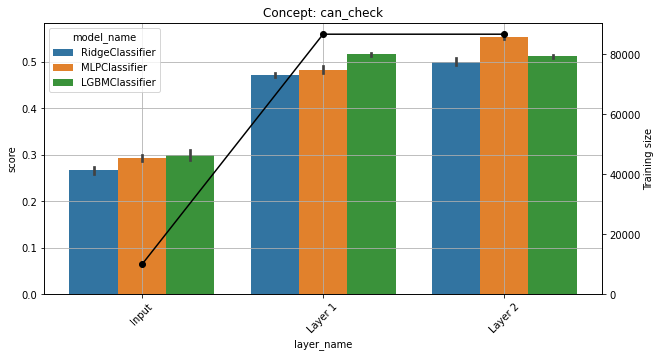

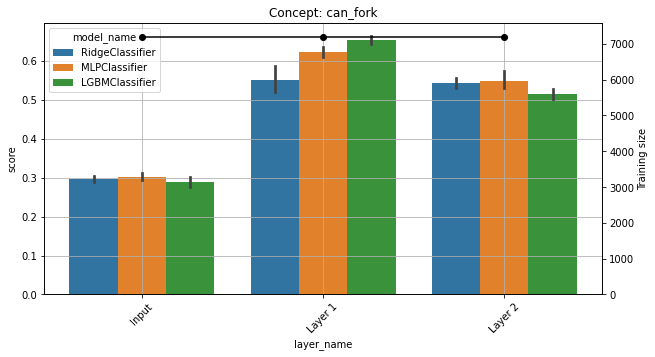

In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# create list from list of lists results
results = [item for sublist in results_classification for item in sublist]
df = pd.DataFrame(results)

layer_name_dict = {1:'Layer 1', 2 : 'Layer 2', 10: 'Input'}
df['layer_name'] = df.layer.apply(lambda x: layer_name_dict[x])
# Create bar plot for each layer
# where x is target, y is score, hue is model_name

# set matplotlib size
for target_name in df.target.unique():
    df_ = df[df.target == target_name]
    plt.rcParams['figure.figsize'] = [10, 5]
    sns.barplot(x='layer_name', y='score', hue='model_name', data=df_)
    plt.xticks(rotation=45)
    plt.title(f'Concept: {target_name}')
    plt.grid()
    
    plt.twinx()
    plt.plot(df_.groupby('layer_name').mean().training_size, color='black', marker='o')
    # increase font size
    plt.xticks(fontsize=20)
    plt.ylabel('Training size')
    plt.ylim(0,)
    #plt.savefig(f'figures/concept_{target_name}.pdf')
    plt.show()

In [ ]:
import pickle as pkl

with open("results/results_2023-02-21 13:23:32.842231.pkl", "rb") as f:
    results_classification = pkl.load(f)


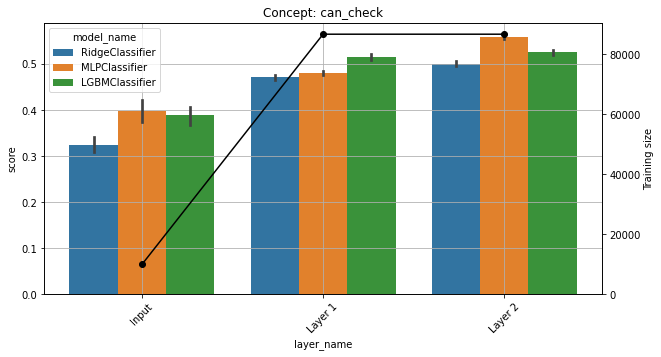

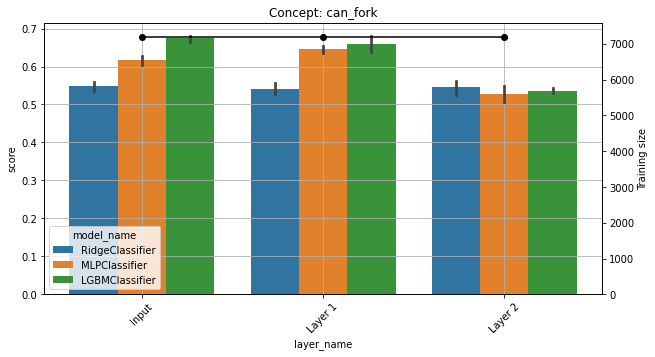

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# create list from list of lists results
results = [item for sublist in results_classification for item in sublist]
df = pd.DataFrame(results)

layer_name_dict = {1:'Layer 1', 2 : 'Layer 2', 10: 'Input'}
df['layer_name'] = df.layer.apply(lambda x: layer_name_dict[x])
# Create bar plot for each layer
# where x is target, y is score, hue is model_name

# set matplotlib size
for target_name in df.target.unique():
    df_ = df[df.target == target_name]
    plt.rcParams['figure.figsize'] = [10, 5]
    sns.barplot(x='layer_name', y='score', hue='model_name', data=df_)
    plt.xticks(rotation=45)
    plt.title(f'Concept: {target_name}')
    plt.grid()
    
    plt.twinx()
    plt.plot(df_.groupby('layer_name').mean().training_size, color='black', marker='o')
    # increase font size
    plt.xticks(fontsize=20)
    plt.ylabel('Training size')
    plt.ylim(0,)
    plt.savefig(f'figures/concept_{target_name}.pdf')
    plt.show()

# OLD

In [2]:
#metric = r2_score
metric = classification_cost
db_name = 'stockfish_data_05'

results_classification = []
for concept in concepts:
    for model in classification_models:

        result = evaluate_concepts_one(
            model,
            metric,
            db_name,
            under_sample=True,
            buckets=["all"],
            drop_zero_values=False,
            regression_to_classification=False,
            inspect_layer=[10,1,2],
            target=concept,
            test_size=0.3,
            num_splits=1,
            print_class_ballance=  True
        )
        results_classification.append(result)

# pickle results with
#  timestamp in string
import pickle
import datetime
file_string = f"results_{datetime.datetime.now()}.pkl"
with open(file_string, "wb") as f:
    pickle.dump(results_classification, f)

print(f'saved file: {file_string}')

  0%|                                                     | 0/1 [00:00<?, ?it/s]19-Dec-22 13:10:24 — root — INFO — starting RidgeClassifier official can_check 10 all
19-Dec-22 13:10:38 — root — INFO — Class distributions: (array([0, 1]), array([43384, 47158]))
19-Dec-22 13:10:40 — root — INFO — Undersampling...
19-Dec-22 13:10:40 — root — INFO — X shape: (86768, 45056)
19-Dec-22 13:10:40 — root — INFO — Class distributions: (array([0, 1]), array([43384, 43384]))
19-Dec-22 13:10:42 — root — INFO — Limiting to 10k samples
19-Dec-22 13:10:42 — root — INFO — X shape: (10000, 45056)
19-Dec-22 13:10:42 — root — INFO — Class distributions: (array([0, 1]), array([4989, 5011]))
19-Dec-22 13:10:45 — root — INFO — score: 0.2933333333333332
19-Dec-22 13:10:45 — root — INFO — starting RidgeClassifier official can_check 1 all
19-Dec-22 13:10:52 — root — INFO — Class distributions: (array([0, 1]), array([43384, 47158]))
19-Dec-22 13:10:52 — root — INFO — Undersampling...
19-Dec-22 13:10:52 — root — I

saved file: results_2022-12-19 13:15:56.400619.pkl


In [3]:
import pickle as pkl

with open("results_2022-12-19 13:15:56.400619.pkl", "rb") as f:
    results_classification = pkl.load(f)

In [8]:
df_.groupby('layer').mean().training_size

layer
1     7196.0
2     7196.0
10    7196.0
Name: training_size, dtype: float64

In [6]:
results_classification

[[{'layer': 10,
   'model_name': 'RidgeClassifier',
   'bucket': 'all',
   'target': 'can_check',
   'score': 0.2933333333333332,
   'training_size': 10000},
  {'layer': 1,
   'model_name': 'RidgeClassifier',
   'bucket': 'all',
   'target': 'can_check',
   'score': 0.4681725634820022,
   'training_size': 86768},
  {'layer': 2,
   'model_name': 'RidgeClassifier',
   'bucket': 'all',
   'target': 'can_check',
   'score': 0.5052821635742,
   'training_size': 86768}],
 [{'layer': 10,
   'model_name': 'MLPClassifier',
   'bucket': 'all',
   'target': 'can_check',
   'score': 0.31066666666666665,
   'training_size': 10000},
  {'layer': 1,
   'model_name': 'MLPClassifier',
   'bucket': 'all',
   'target': 'can_check',
   'score': 0.4621028773385578,
   'training_size': 86768},
  {'layer': 2,
   'model_name': 'MLPClassifier',
   'bucket': 'all',
   'target': 'can_check',
   'score': 0.5469248204064385,
   'training_size': 86768}],
 [{'layer': 10,
   'model_name': 'LGBMClassifier',
   'bucket'

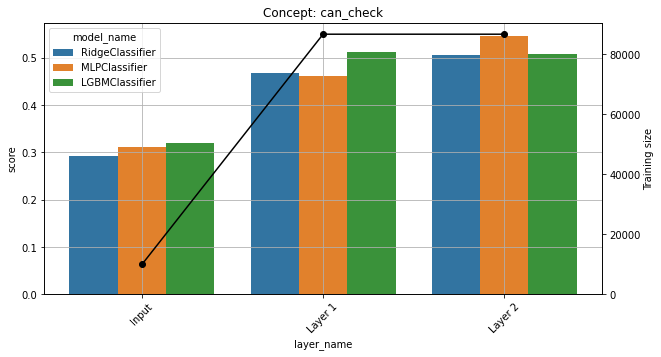

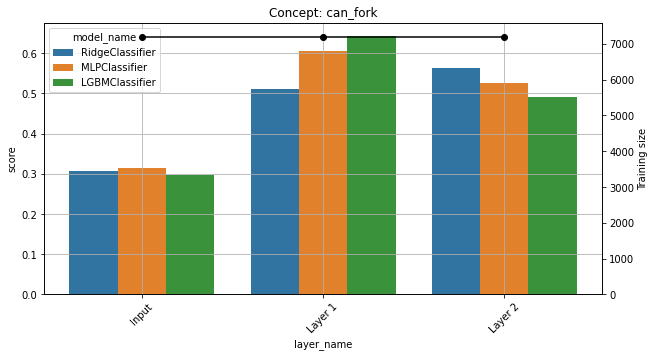

In [16]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# create list from list of lists results
results = [item for sublist in results_classification for item in sublist]
df = pd.DataFrame(results)

layer_name_dict = {1:'Layer 1', 2 : 'Layer 2', 10: 'Input'}
df['layer_name'] = df.layer.apply(lambda x: layer_name_dict[x])
# Create bar plot for each layer
# where x is target, y is score, hue is model_name

# set matplotlib size
for target_name in df.target.unique():
    df_ = df[df.target == target_name]
    plt.rcParams['figure.figsize'] = [10, 5]
    sns.barplot(x='layer_name', y='score', hue='model_name', data=df_)
    plt.xticks(rotation=45)
    plt.title(f'Concept: {target_name}')
    plt.grid()
    
    plt.twinx()
    plt.plot(df_.groupby('layer_name').mean().training_size, color='black', marker='o')
    # increase font size
    plt.xticks(fontsize=20)
    plt.ylabel('Training size')
    plt.ylim(0,)
    plt.savefig(f'concept_{target_name}.pdf')
    plt.show()

In [12]:
df

,layer,model_name,bucket,target,score,training_size
0,10,RidgeClassifier,all,can_fork,0.302455,7196
1,1,RidgeClassifier,all,can_fork,0.497916,7196
2,2,RidgeClassifier,all,can_fork,0.568319,7196
3,10,MLPClassifier,all,can_fork,0.333951,7196
4,1,MLPClassifier,all,can_fork,0.593330,7196
5,2,MLPClassifier,all,can_fork,0.554423,7196
6,10,LGBMClassifier,all,can_fork,0.318203,7196
7,1,LGBMClassifier,all,can_fork,0.655396,7196
8,2,LGBMClassifier,all,can_fork,0.502547,7196


In [3]:

from stockfish_explain.utils.concepts import (
    evaluate_concepts_cv,

)
#metric = r2_score
metric = classification_cost
db_name = 'stockfish_data_05'


results_classification = []
for concept in concepts:
    for model in classification_models:

        result = evaluate_concepts_cv(
            model,
            metric,
            db_name,
            under_sample=True,
            buckets=["all"],
            drop_zero_values=False,
            regression_to_classification=False,
            inspect_layer=[10,1,2],
            target=concept,
            test_size=0.3,
            num_splits=5,
            print_class_ballance=  True
        )
        results_classification.append(result)

# pickle results with
#  timestamp in string
import pickle
import datetime
file_string = f"results_{datetime.datetime.now()}.pkl"
with open(file_string, "wb") as f:
    pickle.dump(results_classification, f)

print(f'saved file: {file_string}')

  0%|          | 0/1 [00:00<?, ?it/s]07-Feb-23 22:01:00 — root — INFO — starting RidgeClassifier official can_check 10 all
07-Feb-23 22:01:15 — root — INFO — Class distributions: (array([0, 1]), array([43384, 47158]))
07-Feb-23 22:01:16 — root — INFO — Undersampling...
07-Feb-23 22:01:16 — root — INFO — X shape: (86768, 45056)
07-Feb-23 22:01:16 — root — INFO — Class distributions: (array([0, 1]), array([43384, 43384]))
07-Feb-23 22:01:18 — root — INFO — Limiting to 10k samples
07-Feb-23 22:01:18 — root — INFO — X shape: (10000, 45056)
07-Feb-23 22:01:18 — root — INFO — Class distributions: (array([0, 1]), array([4989, 5011]))
07-Feb-23 22:01:39 — root — INFO — starting RidgeClassifier official can_check 1 all
07-Feb-23 22:01:46 — root — INFO — Class distributions: (array([0, 1]), array([43384, 47158]))
07-Feb-23 22:01:46 — root — INFO — Undersampling...
07-Feb-23 22:01:46 — root — INFO — X shape: (86768, 2064)
07-Feb-23 22:01:46 — root — INFO — Class distributions: (array([0, 1]), arr

saved file: results_2023-02-07 22:16:13.948826.pkl


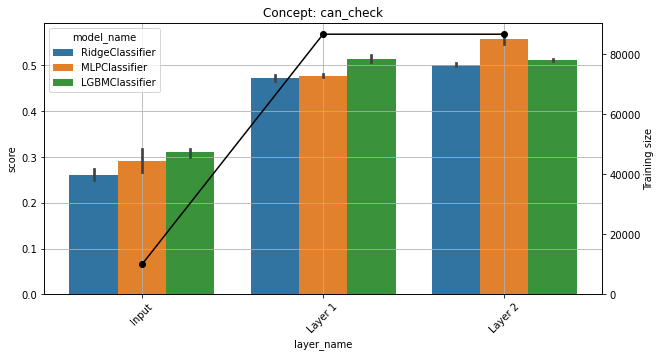

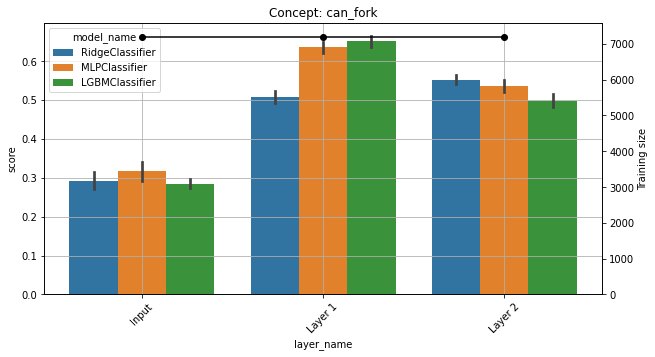

In [4]:

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# create list from list of lists results
results = [item for sublist in results_classification for item in sublist]
df = pd.DataFrame(results)

layer_name_dict = {1:'Layer 1', 2 : 'Layer 2', 10: 'Input'}
df['layer_name'] = df.layer.apply(lambda x: layer_name_dict[x])
# Create bar plot for each layer
# where x is target, y is score, hue is model_name

# set matplotlib size
for target_name in df.target.unique():
    df_ = df[df.target == target_name]
    plt.rcParams['figure.figsize'] = [10, 5]
    sns.barplot(x='layer_name', y='score', hue='model_name', data=df_)
    plt.xticks(rotation=45)
    plt.title(f'Concept: {target_name}')
    plt.grid()
    
    plt.twinx()
    plt.plot(df_.groupby('layer_name').mean().training_size, color='black', marker='o')
    # increase font size
    plt.xticks(fontsize=20)
    plt.ylabel('Training size')
    plt.ylim(0,)
    plt.savefig(f'concept_{target_name}.pdf')
    plt.show()

In [5]:
results

[{'layer': 10,
  'model_name': 'RidgeClassifier',
  'bucket': 'all',
  'target': 'can_check',
  'score': 'fit_time',
  'training_size': 10000},
 {'layer': 10,
  'model_name': 'RidgeClassifier',
  'bucket': 'all',
  'target': 'can_check',
  'score': 'score_time',
  'training_size': 10000},
 {'layer': 10,
  'model_name': 'RidgeClassifier',
  'bucket': 'all',
  'target': 'can_check',
  'score': 'test_score',
  'training_size': 10000},
 {'layer': 10,
  'model_name': 'RidgeClassifier',
  'bucket': 'all',
  'target': 'can_check',
  'score': 'train_score',
  'training_size': 10000},
 {'layer': 1,
  'model_name': 'RidgeClassifier',
  'bucket': 'all',
  'target': 'can_check',
  'score': 'fit_time',
  'training_size': 86768},
 {'layer': 1,
  'model_name': 'RidgeClassifier',
  'bucket': 'all',
  'target': 'can_check',
  'score': 'score_time',
  'training_size': 86768},
 {'layer': 1,
  'model_name': 'RidgeClassifier',
  'bucket': 'all',
  'target': 'can_check',
  'score': 'test_score',
  'training

# Tree regression example

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

metric = classification_cost
db_name = 'stockfish_data_05'

inspect_layer=[10,1,2]
buckets = ['all']
num_splits=5
test_size = 0.33
concept_file = "/media/ap/storage/stockfish_data/concept_table3.csv"

concept_models = [
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
]

ckpt = 'official'

df = pd.read_csv(concept_file)

bucket_values = np.array(df.bucket.values)

total_steps = len(concepts) * len(classification_models) * len(inspect_layer) * len(buckets)

results_classification = []
with tqdm(total=total_steps) as pbar:
    for target in concepts:
        for model in concept_models:
            for layer in inspect_layer:
                for bucket in buckets:


                    results = []

                    model_name = f"{model.__class__.__name__}"
                    log.debug(f'starting {model_name} {ckpt} {target} {layer} {bucket}')

                    # Build dataset

                    ## fetch targets
                    y = np.array(df[target].values)
                    if y.dtype == bool:
                        y = y.astype(int)



                    ## Load input
                    sh = shelve.open(f"/media/ap/storage/stockfish_data/{db_name}")
                    X = np.array(sh["ckpt_data_" + ckpt][f"layer{layer}"])
                    sh.close()
                    X = X.reshape(X.shape[0], -1)

                    log.debug(f'X shape: {X.shape}, y shape {y.shape}')


                    # Remove rows where target is None
                    y_not_None = np.where(y != None)[0].astype(int)
                    y_not_None = y != None
                    X, y = X[y_not_None], y[y_not_None]

                    if bucket != "all":
                        assert bucket in [0, 1, 2, 3, 4, 5, 6, 7]

                        bucket_chosen = bucket_values == bucket
                        # print(f'Bucket: {bucket}')
                        # print(f'shape before bucket filtering: {y.shape[0]}')
                        X, y = X[bucket_chosen], y[bucket_chosen]
                        # print(f'shape after bucket filtering: {y.shape[0]}')
                        log.debug(f'choosing bucket {bucket}')
                        log.debug(f'X shape: {X.shape}')



                    log.debug(f'Class distributions: {value_counts(y)}')

                    undersample = RandomUnderSampler(
                        sampling_strategy="majority"
                    )
                    # fit and apply the transform
                    X, y = undersample.fit_resample(X, list(y * 1))
                    log.debug('Undersampling...')
                    log.debug(f'X shape: {X.shape}')


                    log.debug(f'Class distributions: {value_counts(y)}')

                    if layer == 10:
                        max_samples = 10000
                        if len(y) > max_samples:
                            # choose 10k random samples from the data
                            _, X, _, y = train_test_split(
                                X, y, test_size=max_samples, random_state=42
                            )
                        log.debug('Limiting to 10k samples')
                        log.debug(f'X shape: {X.shape}')


                    log.debug(f'Class distributions: {value_counts(y)}')


                    # split into train and test sets 
                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=test_size, random_state=42, stratify=y
                    )


                    size = len(X[0])

                    model.fit(X_train, list(y_train))
                    y_pred = model.predict(X_test)

                    score = metric(y_test, y_pred)

                    score_test = []
                    for pred in model.staged_predict(X_test):
                        score_test.append(metric(y_test, pred))

                    # calculate confusion matrix


                    results_ = {'model_name': model_name,
                                'input_name': layer, 
                                'target_name': target,
                                'score': score, 
                                'size': size,
                                'test_scores': score_test}
                    results_classification.append(results_)
                    
                    

                    
                    pbar.update(1)

# pickle results with
#  timestamp in string
import pickle
import datetime
file_string = f"results/results_{datetime.datetime.now()}.pkl"
with open(file_string, "wb") as f:
    pickle.dump(results_classification, f)

print(f'saved file: {file_string}')

  0%|                                                    | 0/18 [00:00<?, ?it/s]20-Feb-23 16:06:38 — notebook — DEBUG — starting GradientBoostingClassifier official can_check 10 all
20-Feb-23 16:06:58 — notebook — DEBUG — X shape: (90542, 45056), y shape (90542,)
20-Feb-23 16:07:15 — notebook — DEBUG — Class distributions: (array([0, 1]), array([43384, 47158]))
20-Feb-23 16:07:21 — notebook — DEBUG — Undersampling...
20-Feb-23 16:07:21 — notebook — DEBUG — X shape: (86768, 45056)
20-Feb-23 16:07:21 — notebook — DEBUG — Class distributions: (array([0, 1]), array([43384, 43384]))
20-Feb-23 16:07:23 — notebook — DEBUG — Limiting to 10k samples
20-Feb-23 16:07:23 — notebook — DEBUG — X shape: (10000, 45056)
20-Feb-23 16:07:23 — notebook — DEBUG — Class distributions: (array([0, 1]), array([4989, 5011]))
  6%|██▎                                      | 1/18 [07:17<2:04:01, 437.71s/it]20-Feb-23 16:13:56 — notebook — DEBUG — starting GradientBoostingClassifier official can_check 1 all
20-Feb-2

saved file: results_2023-02-20 16:33:30.624888.pkl


21-Feb-23 10:02:24 — matplotlib.backends.backend_pdf — DEBUG — Assigning font /b'F1' = '/home/ap/miniconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
21-Feb-23 10:02:24 — matplotlib.backends.backend_pdf — DEBUG — Embedding font /home/ap/miniconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
21-Feb-23 10:02:24 — matplotlib.backends.backend_pdf — DEBUG — Writing TrueType font.


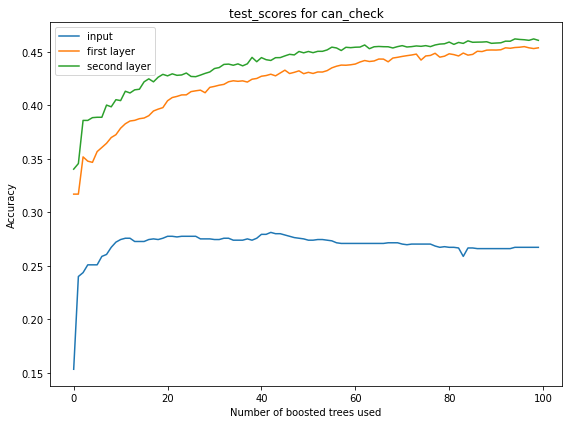

21-Feb-23 10:02:24 — matplotlib.backends.backend_pdf — DEBUG — Assigning font /b'F1' = '/home/ap/miniconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
21-Feb-23 10:02:24 — matplotlib.backends.backend_pdf — DEBUG — Embedding font /home/ap/miniconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
21-Feb-23 10:02:24 — matplotlib.backends.backend_pdf — DEBUG — Writing TrueType font.


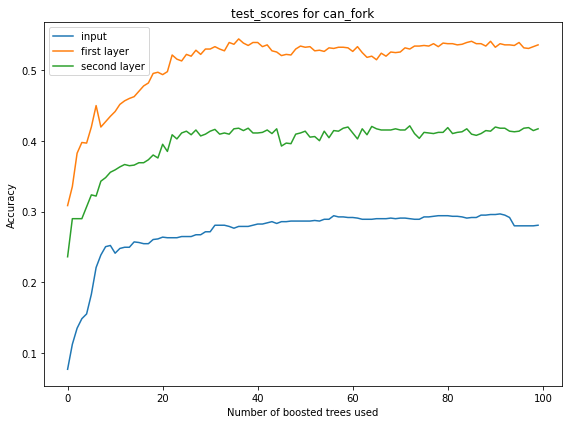

In [18]:
import matplotlib.pyplot as plt
import pickle as pkl

with open('results/results_2023-02-20 16:33:30.624888.pkl', 'rb') as file:
    results = pkl.load(file)
    
    
layer_dict = {10: 'input',
              1: 'first layer',
              2: 'second layer'}

# set pyplot firure size
plt.rcParams["figure.figsize"] = (8,6)
# plot test_scores for each target_name and input_name in results
# filter results for target_name
for target_name in concepts:
    for input_name in inspect_layer:
        for result in results:
            if result['target_name'] == target_name and result['input_name'] == input_name:
                plt.plot(result['test_scores'], label=f"{layer_dict[result['input_name']]}")

    plt.legend()
    plt.title(f"test_scores for {target_name}")
    plt.xlabel('Number of boosted trees used')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.savefig(f'figures/boosting_stockfish_{target_name}.pdf')
    plt.show()


# Can fork larger dataset

In [6]:
db_name = 'stockfish_data_v8_can_fork'
sh = shelve.open(f"/media/ap/storage/stockfish_data/{db_name}")
bucket_nums = np.array(sh[f"layer6"])
sh.close()
bucket_nums = bucket_nums.reshape(-1)
bucket_nums

array([3, 0, 1, ..., 7, 6, 7])

In [4]:
df.head().T

,0,1,2,3,4
fen,3k4/1p6/3b4/1P1pp3/N2P3r/4PK2/1P6/2R5 w - - 2 54,3k4/5Q2/r7/3K4/8/8/8/8 w - - 27 86,1Q6/8/6pk/8/4q3/8/2K5/8 w - - 1 63,3qr1k1/p1R2p1p/1p1npn2/3p2N1/3P2P1/3NP2P/2Q2PK...,8/8/8/8/6b1/8/2k1p3/4K3 w - - 2 55
black_pawn,3.0,0.0,1.0,6.0,1.0
black_king,1,1,1,1,1
black_knight,0.0,0.0,0.0,2.0,0.0
white_pawn,4.0,0.0,0.0,5.0,0.0
white_king,1,1,1,1,1
white_to_move,1,1,1,1,1
black_rook,1.0,1.0,0.0,1.0,0.0
black_queen,0.0,0.0,1.0,1.0,0.0
black_bishop,1.0,0.0,0.0,0.0,1.0


In [ ]:
metric = classification_cost
db_name = 'stockfish_data_v8_can_fork'

inspect_layer=[1,2,5]
buckets = ['all',0,1,2,3,4,5,6,7]
num_splits=5

limit_all = False

concept_file = "/media/ap/storage/stockfish_data/concept_table_ballanced_can_fork_white_to_move.csv"


sh = shelve.open(f"/media/ap/storage/stockfish_data/{db_name}")
bucket_nums = np.array(sh[f"layer6"])
sh.close()
bucket_nums = bucket_nums.reshape(-1)



df = pd.read_csv(concept_file)

df['bucket'] = bucket_nums

bucket_values = np.array(df.bucket.values)

total_steps = len(concepts) * len(classification_models) * len(inspect_layer) * len(buckets)

results_classification = []
with tqdm(total=total_steps) as pbar:
    for target in concepts:
        for model in classification_models:
            for layer in inspect_layer:
                for bucket in buckets:


                    results = []

                    model_name = f"{model.__class__.__name__}"
                    log.debug(f'starting {model_name} {target} {layer} {bucket}')

                    # Build dataset

                    ## fetch targets
                    y = np.array(df[target].values)
                    if y.dtype == bool:
                        y = y.astype(int)



                    ## Load input
                    sh = shelve.open(f"/media/ap/storage/stockfish_data/{db_name}")
                    X = np.array(sh[f"layer{layer}"])
                    sh.close()
                    X = X.reshape(X.shape[0], -1)

                    log.debug(f'X shape: {X.shape}, y shape {y.shape}')


                    # Remove rows where target is None
                    y_not_None = np.where(y != None)[0].astype(int)
                    y_not_None = y != None
                    X, y = X[y_not_None], y[y_not_None]

                    if bucket != "all":
                        assert bucket in [0, 1, 2, 3, 4, 5, 6, 7]

                        bucket_chosen = bucket_values == bucket
                        # print(f'Bucket: {bucket}')
                        # print(f'shape before bucket filtering: {y.shape[0]}')
                        X, y = X[bucket_chosen], y[bucket_chosen]
                        # print(f'shape after bucket filtering: {y.shape[0]}')
                        log.debug(f'choosing bucket {bucket}')
                        log.debug(f'X shape: {X.shape}')



                    log.debug(f'Class distributions: {value_counts(y)}')

                    undersample = RandomUnderSampler(
                        sampling_strategy="majority"
                    )
                    # fit and apply the transform
                    X, y = undersample.fit_resample(X, list(y * 1))
                    log.debug('Undersampling...')
                    log.debug(f'X shape: {X.shape}')


                    log.debug(f'Class distributions: {value_counts(y)}')

                    if layer == 10:
                        max_samples = 10000
                        if len(y) > max_samples:
                            # choose 10k random samples from the data
                            _, X, _, y = train_test_split(
                                X, y, test_size=max_samples, random_state=42
                            )
                        log.debug('Limiting to 10k samples')
                        log.debug(f'X shape: {X.shape}')
                        
                    if limit_all:
                        max_samples = limit_all
                        if len(y) > max_samples:
                            # choose 10k random samples from the data
                            _, X, _, y = train_test_split(
                                X, y, test_size=max_samples, random_state=42
                            )
                        log.debug('Limiting to 10k samples')
                        log.debug(f'X shape: {X.shape}')


                    log.debug(f'Class distributions: {value_counts(y)}')


                    scores  = cross_validate(model, X, y, cv=num_splits, 
                            scoring=make_scorer(metric, greater_is_better=True), return_train_score=True)




                    for score in scores['test_score']:
                        results_ = {
                            "layer": layer,
                            "model_name": model_name,
                            "bucket": bucket,
                            "target": target,
                            "score": score,
                            "training_size": X.shape[0],
                        }

                        results.append(results_)



                    results_classification.append(results)
                    
                    pbar.update(1)

# pickle results with
#  timestamp in string
import pickle
import datetime
file_string = f"results/results_{datetime.datetime.now()}.pkl"
with open(file_string, "wb") as f:
    pickle.dump(results_classification, f)

print(f'saved file: {file_string}')

  0%|                                                                                                                                        | 0/162 [00:00<?, ?it/s]/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.61812e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.65999e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.63418e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.81

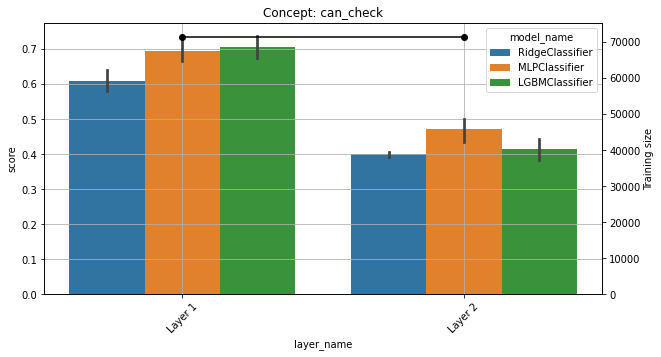

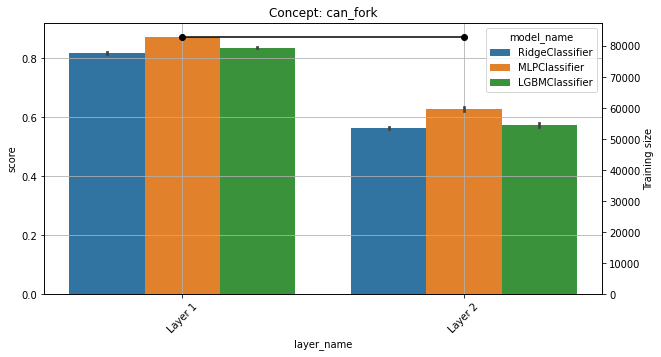

In [2]:
import matplotlib.pyplot as plt
import pickle as pkl

with open('results/results_2023-02-21 12:09:33.944092.pkl', 'rb') as file:
    results = pkl.load(file)
    
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# create list from list of lists results
results = [item for sublist in results for item in sublist]
df = pd.DataFrame(results)

layer_name_dict = {1:'Layer 1', 2 : 'Layer 2', 10: 'Input'}
df['layer_name'] = df.layer.apply(lambda x: layer_name_dict[x])
# Create bar plot for each layer
# where x is target, y is score, hue is model_name

# set matplotlib size
for target_name in df.target.unique():
    df_ = df[df.target == target_name]
    plt.rcParams['figure.figsize'] = [10, 5]
    sns.barplot(x='layer_name', y='score', hue='model_name', data=df_)
    plt.xticks(rotation=45)
    plt.title(f'Concept: {target_name}')
    plt.grid()
    
    plt.twinx()
    plt.plot(df_.groupby('layer_name').mean().training_size, color='black', marker='o')
    # increase font size
    plt.xticks(fontsize=20)
    plt.ylabel('Training size')
    plt.ylim(0,)
    plt.savefig(f'figures/concept_{target_name}.pdf')
    plt.show()

21-Feb-23 12:20:54 — matplotlib.backends.backend_pdf — DEBUG — Assigning font /b'F1' = '/home/ap/miniconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
21-Feb-23 12:20:54 — matplotlib.backends.backend_pdf — DEBUG — Embedding font /home/ap/miniconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
21-Feb-23 12:20:54 — matplotlib.backends.backend_pdf — DEBUG — Writing TrueType font.


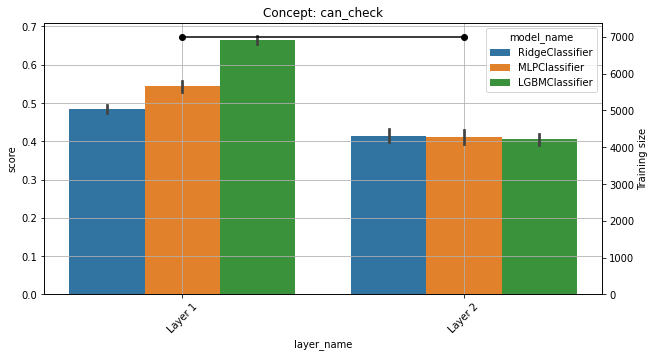

21-Feb-23 12:20:54 — matplotlib.backends.backend_pdf — DEBUG — Assigning font /b'F1' = '/home/ap/miniconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
21-Feb-23 12:20:54 — matplotlib.backends.backend_pdf — DEBUG — Embedding font /home/ap/miniconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
21-Feb-23 12:20:54 — matplotlib.backends.backend_pdf — DEBUG — Writing TrueType font.


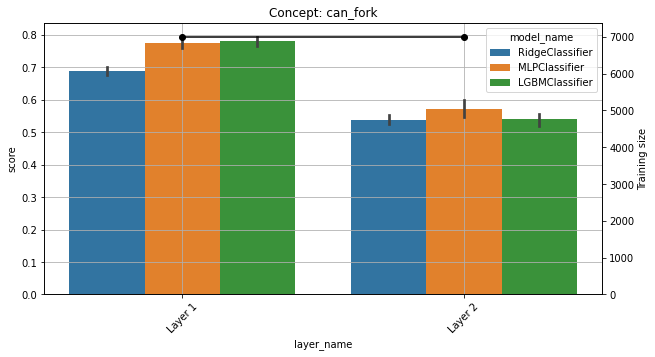

In [6]:
import matplotlib.pyplot as plt
import pickle as pkl

with open('results/results_2023-02-21 12:20:41.092445.pkl', 'rb') as file:
    results = pkl.load(file)
    
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# create list from list of lists results
results = [item for sublist in results for item in sublist]
df = pd.DataFrame(results)

layer_name_dict = {1:'Layer 1', 2 : 'Layer 2', 10: 'Input'}
df['layer_name'] = df.layer.apply(lambda x: layer_name_dict[x])
# Create bar plot for each layer
# where x is target, y is score, hue is model_name

# set matplotlib size
for target_name in df.target.unique():
    df_ = df[df.target == target_name]
    plt.rcParams['figure.figsize'] = [10, 5]
    sns.barplot(x='layer_name', y='score', hue='model_name', data=df_)
    plt.xticks(rotation=45)
    plt.title(f'Concept: {target_name}')
    plt.grid()
    
    plt.twinx()
    plt.plot(df_.groupby('layer_name').mean().training_size, color='black', marker='o')
    # increase font size
    plt.xticks(fontsize=20)
    plt.ylabel('Training size')
    plt.ylim(0,)
    plt.savefig(f'figures/concept_{target_name}.pdf')
    plt.show()